# Optimization with light-cones

This notebook shows how to optimize QAOA circuits with the light-cone energy evaluation and the wrapper of SciPy's optimize function. The light-cone evaluation of a QAOA circuit is described in an Appendix of the paper "Large-scale quantum approximate optimization on nonplanar graphs with machine learning noise mitigation" published in Phys. Rev. Research **6** and found [here](https://doi.org/10.1103/PhysRevResearch.6.013223).

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Sampler

from qiskit_aer import AerSimulator

from qiskit_optimization.applications import Maxcut

from qaoa_training_pipeline.evaluation import LightConeEvaluator
from qaoa_training_pipeline.training import ScipyTrainer, TransitionStatesTrainer
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator
from qaoa_training_pipeline.utils.data_utils import samples_to_objective_values
from qaoa_training_pipeline.visualization.plotting import plot_cdf

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


First, we generate a problem to optimize. Here, we consider a MaxCut on random-three-regular graph. The cost operator for this problem is of the form

\begin{align}
H_C=-\frac{1}{2}\sum_{i,j}Z_iZ_j
\end{align}

In [2]:
graph = nx.random_regular_graph(d=3, n=20)
cost_op = graph_to_operator(graph, pre_factor=-0.5)

### Depth-one optimization

In the following cell we first optimize a depth-one QAOA with the light-cone. Next, we use the resulting optimal depth-one parameters to optimize the depth-two QAOA, again using the light-cone as evaluator. The largest circuit that is ever evaluated here is for the depth-two QAOA and has 14 qubits. This is smaller than the full problem size which requires 20 qubits, i.e., one for each node in the graph. This is because we leverage the light-cone of the correlators that we want to evaluate to reduce the size of the circuit.

In [3]:
trainer1 = ScipyTrainer(LightConeEvaluator())
params1 = trainer1.train(cost_op, [0, 0])
print("Done optimizing depth-1 QAOA")

Done optimizing depth-1 QAOA


In [4]:
print("Depth-one results:\n", params1["optimized_params"], "\n")

Depth-one results:
 [1.1990322219315326, -0.5950398319843925] 



### Depth-two optimization

To perform the depth-two optimization we will use the transition state trainer. This trainer is based on the work by S. Sack published in Phys. Rev. A **107** and found [here](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.062404). It will use the depth $p=1$ optimal point found above and explore an additional $2p+1=3$ points known as Transition States.

In [5]:
trainer2 = ScipyTrainer(LightConeEvaluator(), {"options": {"maxiter": 40, "rhobeg": 0.2}})
ts_trainer = TransitionStatesTrainer(trainer2)
params2 = ts_trainer.train(cost_op, params1["optimized_params"])

The result of the optimization is shown below.

In [6]:
print("Depth-two results:\n", params2["optimized_params"])

Depth-two results:
 [1.0476913641068029, -0.276328868840032, -0.4856159813630307, -0.8904965171858611]


Now, we also create the distrubutions we obtain when sampling from the optimized parameters. Here, this is possible in simulation because we chose a small problem that still fits in the Qiskit Aer simulator. The sampling done below will not be possible in a simulation as $n$ increases. Indeed, this sampling tasks requires $O(2^n)$ space on a classical computer. By contrast, we can still optimize $\beta$ and $\gamma$ with the light-cone evaluator as we increase the size $n$ of the random three-regular graph. Indeed, the light-cone evaluator functions with expectation values and runs in $O(n)$ time. The linear runtime in system size $n$ happens because a random $k$-regular graph has $kn/2$ edges. Therefore, the number of edges, which determines how many circuits must be evaluated, increases linearly with $n$. Crucially, the width of these circuits is given by the QAOA depth $p$ and the regularity $k$ of the graph. The light-cone evaluator runtime thus scales exponentially in $p$ and $k$. 

In [7]:
shots = 1024
ansatz, circuits = QAOAAnsatz(cost_op, reps=2).decompose(), []
opt_depth1 = [params1["optimized_params"][0], 0, params1["optimized_params"][1], 0]
ansatz.measure_all()
for param_set in [[0, 0, 0, 0], opt_depth1, params2["optimized_params"]]:
    circuits.append(ansatz.assign_parameters(param_set, inplace=False))

isa_circuits = transpile(circuits, basis_gates=["sx", "x", "cx", "rz"])
sampler = Sampler(mode=AerSimulator())
result = sampler.run(isa_circuits, shots=shots).result()

We prepare the data on the parameter optimization and the sampling for plotting.

In [8]:
program = Maxcut(graph).to_quadratic_program()

func_results = [
    samples_to_objective_values(
        {k: v / shots for k, v in res.data.meas.get_counts().items()}, program
    )
    for res in result
]

For reference, we also plot the exact solution which we can find with CPLEX.

In [9]:
from qiskit_optimization.algorithms import CplexOptimizer

sol = CplexOptimizer().solve(program)
sol.fval

26.0

Text(0, 0.5, 'CDF')

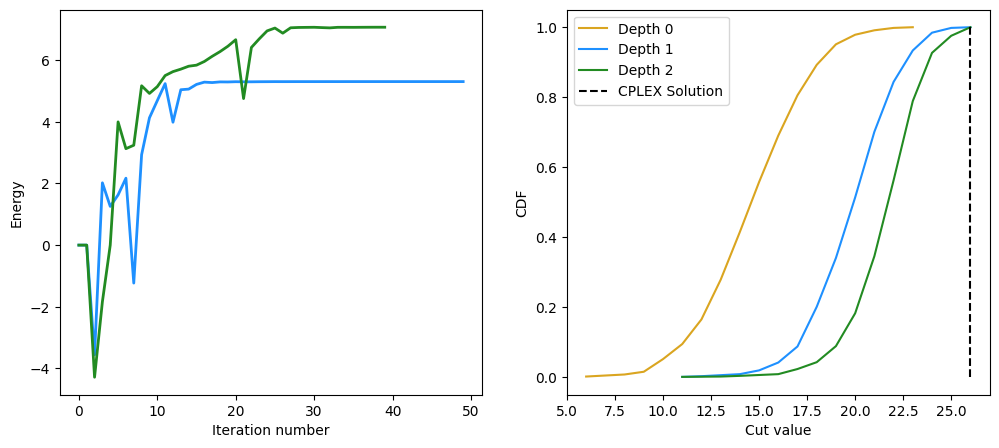

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
trainer1.plot(axs[0], fig, color="dodgerblue", lw=2)
trainer2.plot(axs[0], fig, color="forestgreen", lw=2)
colors = ["goldenrod", "dodgerblue", "forestgreen"]
for idx in [0, 1, 2]:
    plot_cdf(func_results[idx], axis=axs[1], label=f"Depth {idx}", color=colors[idx])

axs[1].plot([sol.fval, sol.fval], [0, 1], "--k", label="CPLEX Solution")
axs[1].legend()
axs[1].set_xlabel("Cut value")
axs[1].set_ylabel("CDF")

The left panel shows the maximization of the energy as a function of iteration. The right panel shows the cumulative distribution function (CDF) of the cut values for random sampling (Depth 0), depth-one QAOA (Depth 1) and depth-two QAOA (Depth 2). The dashed vertical line shows the optimal solution value found with CPLEX.